In [48]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np

## Задача 1.

Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote)

In [24]:
"""
Полжим сюда семечко 
"""
random.seed(42)

In [49]:
"""
Формируем датасет при помощи sklearn 
"""

classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=38)

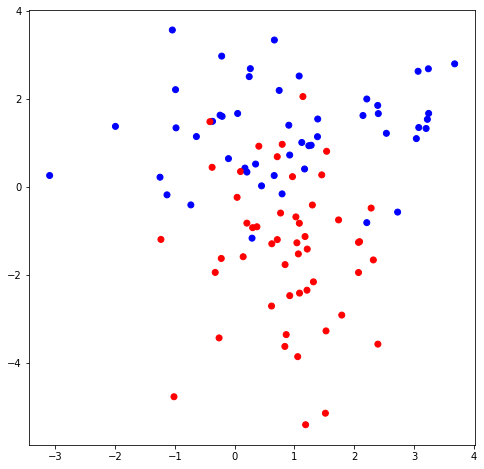

In [26]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightgreen', 'lightyellow'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)



## Задача 3.

Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [28]:
random.seed(42)

def get_bootstrap(data, labels, N) -> (list, list):
    n_samples = data.shape[0]
    bootstrap = []
    
    # Для каждого наблюдения будем хранить множество индексов - номеров деревьев, в обучении которых он не участвовал
    out_of_bag = [set(np.arange(N)) for _ in range(data.shape[0])]
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            out_of_bag[sample_index].discard(i)
        bootstrap.append((b_data, b_labels))
        
    return bootstrap, out_of_bag

In [29]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    subsample = sample_indexes[0:len_subsample].copy()
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    return subsample

In [30]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [31]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels, index):
        self.index = index
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [32]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [33]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [34]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [35]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [36]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels, index)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


In [37]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, out_of_bag = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, out_of_bag

In [38]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [39]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


In [40]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [41]:
# Расчет OOB
def oob(forest, out_of_bag, data, labels):
    res = 0
    for idx, item in enumerate(out_of_bag):
        # для каждого индекса в out_of_bag строим лес из деревьев, не использовавших индекс
        tmp_forest = [forest[j] for j in item]
        tmp_data = np.array([data[idx]])
        tmp_label = labels[idx]
        
        if tmp_forest:
            predictions = tree_vote(tmp_forest, tmp_data)
            for j in predictions:
                if j != tmp_label:
                    res += 1 / len(tmp_forest)
       
    return res


In [51]:


# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 42)



In [45]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [46]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [60]:


def build_forest_viz(n_trees, train_data, train_labels, test_data):
    my_forest, out_of_bag = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    train_oob = oob(my_forest, out_of_bag, train_data, train_labels)
    print(f'OOB случайного леса из {n_trees} деревьев на тестовой выборке: {train_oob:.3f}')
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    



Точность случайного леса из 1 деревьев на обучающей выборке: 87.143
Точность случайного леса из 1 деревьев на тестовой выборке: 93.333
OOB случайного леса из 1 деревьев на тестовой выборке: 6.000


NameError: name 'plasma' is not defined

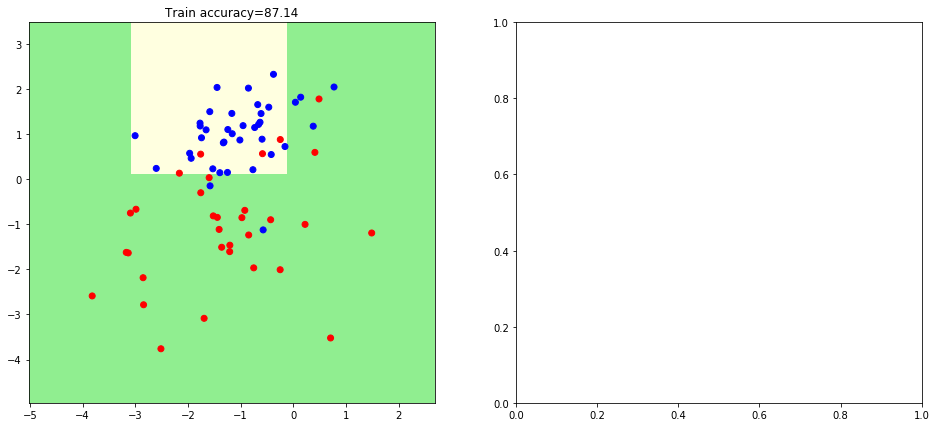

In [61]:
build_forest_viz(1, train_data, train_labels, test_data)

Точность случайного леса из 3 деревьев на обучающей выборке: 91.429
Точность случайного леса из 3 деревьев на тестовой выборке: 90.000
OOB случайного леса из 3 деревьев на тестовой выборке: 8.333


NameError: name 'plasma' is not defined

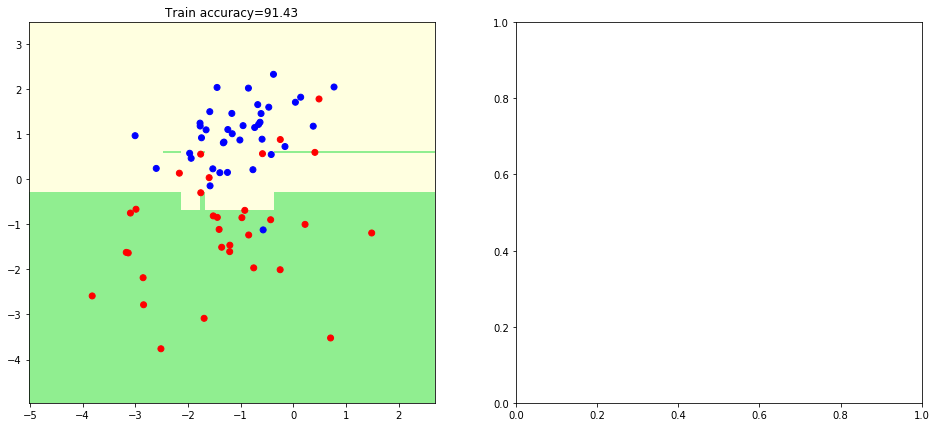

In [62]:
# Лес из 3 деревьев
build_forest_viz(3, train_data, train_labels, test_data)

Точность случайного леса из 10 деревьев на обучающей выборке: 91.429
Точность случайного леса из 10 деревьев на тестовой выборке: 93.333
OOB случайного леса из 10 деревьев на тестовой выборке: 8.417


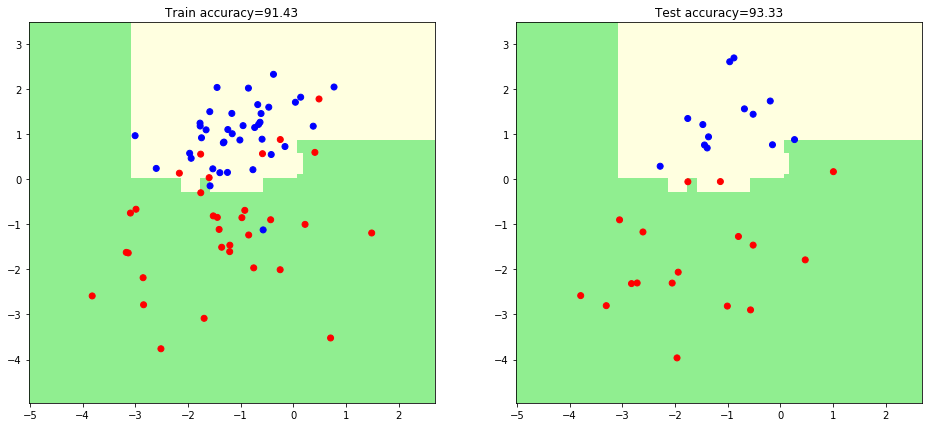

In [55]:
# Лес из 10 деревьев
build_forest_viz(10, train_data, train_labels, test_data)

Точность случайного леса из 50 деревьев на обучающей выборке: 90.000
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667
OOB случайного леса из 50 деревьев на тестовой выборке: 0.479


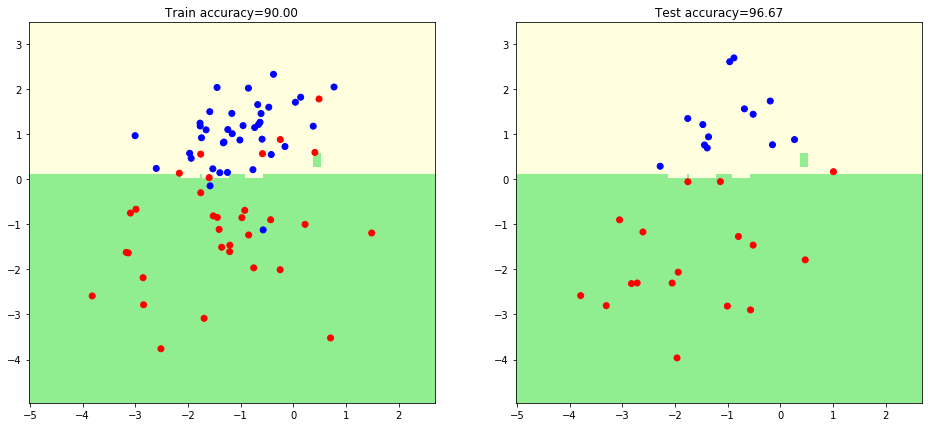

In [56]:
# Лес из 50 деревьев
build_forest_viz(50, train_data, train_labels, test_data)

# Задача 2.

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

 Как писал в статье на хабре, при увеличение количества деревьев, точность на тестовых данных выходит на ассимптоту

# Задача 4.

Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [59]:


from math import log2

def calc_entropy(x, y, t):
    qty_all = len(y)
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    # Индекс Джини не будет равен бесконечности в таком случае,
    # но и считать его особо смысла нет, т.к. получается только одна ветвь
    if qty_left == 0 or qty_right == 0:
        return 0

    qty0_left = ((y[x < t]) == 0).sum()
    qty0_right = ((y[x >= t]) == 0).sum()

    p0_left = qty0_left / qty_left
    p1_left = 1 - p0_left

    p0_right = qty0_right / qty_right
    p1_right = 1 - p0_right

    # Нормировочный коэффициент для левого листа
    left_coef = qty_left / qty_all

    # энтропия для левого листа
    h_left = p0_left * log2(p0_left) + p1_left * log2(p1_left)
    # энтропия для правого листа
    h_right = p0_right * log2(p0_right) + p1_right * log2(p1_right)

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

# Расчет энтропии

def shannon(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * log2(p)
        
    return impurity, classes
